In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from shapely import to_geojson

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances, pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering

import libpysal
import spopt
import esda
import networkx as nx
import pygeoda

import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as ctx

import folium
from folium.plugins import GroupedLayerControl
from jinja2 import Template

import os
from pathlib import Path

from src import config, utils, plotting, algorithms, evaluation

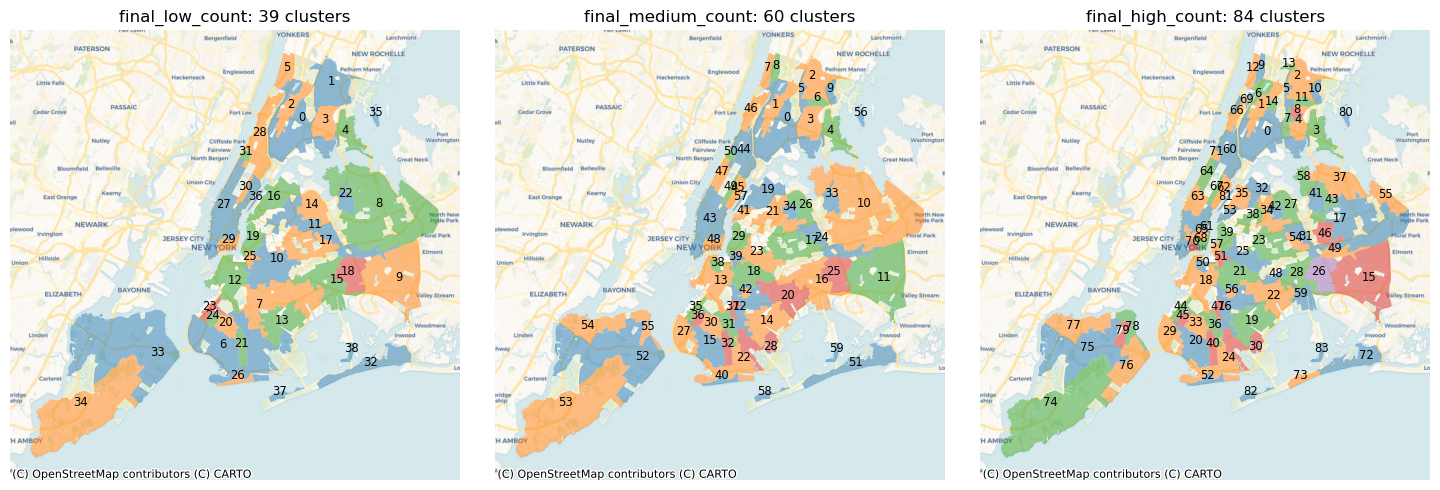

In [3]:
# Load in features and add frac_black back in for interpretability; it was removed to prevent collinearity in model fitting)
features = pd.read_parquet(config.FEATURES_11)
features.insert(0, "frac_black", 
                1 - features[["frac_white","frac_hispanic","frac_raceother"]].sum(axis=1)
)
feature_attrs = features.columns
features_std = pd.DataFrame(
    StandardScaler().fit_transform(features),
    index=features.index,
    columns=features.columns
)

# Load in geometries and join with feature info
tracts = gpd.read_parquet(config.TRACTS_CLEAN)
nyc_demographics = tracts.join(features)
nyc_demographics_std = tracts.join(features_std)

# Load in clustering labels and join to full dataset
final_model_names = ["final_low_count", "final_medium_count", "final_high_count"]
for model_name in final_model_names:
    model = pd.read_parquet(config.MODEL_DIR / f"~{model_name}.parquet")
    nyc_demographics = nyc_demographics.join(model)
    nyc_demographics_std = nyc_demographics_std.join(model)

# Load NTAs
ntas = gpd.read_parquet(config.NYC_NTAS_CLEAN)

# Plot side by side
fig, ax = plt.subplots(1,3, figsize=(15, 5))
for i, model_name in enumerate(final_model_names):
    __, __ = plotting.plot_clusters(nyc_demographics, model_name,
                                    figax=(fig, ax[i]))
    
    NC = len(nyc_demographics[model_name].unique())

    ax[i].set_title(f"{model_name}: {NC} clusters")

# Folium

In [4]:
DOCS_DIR = Path("docs")
MAP_DIR = DOCS_DIR / "maps"
MAPDATA_DIR = MAP_DIR / "data"

os.makedirs(DOCS_DIR, exist_ok=True)
os.makedirs(MAP_DIR, exist_ok=True)
os.makedirs(MAPDATA_DIR, exist_ok=True)

MAP_FILE = MAP_DIR / "map_clusters.html"

## Save cluster and NTA GeoJSON

According to ChatGPT, it's fine to directly embed GeoJSON into the HTML file as long as the file size stays under 5 MB (for fast loading). Still, it's probably good practice to save the files separately. I'm putting them in `docs/maps/data`, for the eventual Folium map to be in `docs/maps`.

In [5]:
model_names = ["final_low_count", "final_medium_count", "final_high_count"]
for model_name in model_names:
    # Make clusters
    clusters = utils.aggregate_clusters(nyc_demographics, feature_attrs, model_name)
    clusters = clusters.drop(columns=[
        "AREA","LAT","LONG"
    ])

    # Convert to WGS84 lat/lon if not already (Folium expects this)
    clusters = clusters.to_crs(config.WGS84_EPSG)

    # Simplify geometries to reduce file size (tolerance in degrees)
    clusters["geometry"] = clusters.geometry.simplify(
        tolerance=0.00001,           # ~1 meter at NYC latitude (1 deg ~ 100 km for most latitudes)
        preserve_topology=True
    )
    clusters.index.name = "label"

    # Save to GeoJSON
    file_name = f"clusters_{model_name[6:]}.geojson"
    clusters.to_file(MAPDATA_DIR / file_name, driver="GeoJSON")

In [6]:
# Load in and simplify NTA GeoDataFrame
ntas = gpd.read_parquet(config.NYC_NTAS_CLEAN)
ntas = ntas[[
    "boroname", "nta2020", "ntaname", "ntaabbrev", "geometry"
]]

# Convert to WGS84 lat/lon if not already (Folium expects this)
ntas = ntas.to_crs(config.WGS84_EPSG)

# Simplify geometries to reduce file size (tolerance in degrees)
ntas["geometry"] = ntas.geometry.simplify(
    tolerance=0.00001,           # ~1 meter at NYC latitude (1 deg ~ 100 km for most latitudes)
    preserve_topology=True
)
ntas.index.name = "label"

# Save to GeoJSON
file_name = "ntas.geojson"
ntas.to_file(MAPDATA_DIR / file_name, driver="GeoJSON")

In [7]:
# Load in and simplify NTA GeoDataFrame
tracts = gpd.read_parquet(config.TRACTS_CLEAN)

# Convert to WGS84 lat/lon if not already (Folium expects this)
tracts = tracts.to_crs(config.WGS84_EPSG)

# Simplify geometries to reduce file size (tolerance in degrees)
tracts["geometry"] = tracts.geometry.simplify(
    tolerance=0.00001,           # ~1 meter at NYC latitude (1 deg ~ 100 km for most latitudes)
    preserve_topology=True
)
tracts.index.name = "label"

# Save to GeoJSON
file_name = "tracts.geojson"
tracts.to_file(MAPDATA_DIR / file_name, driver="GeoJSON")

## Create Map object

In [8]:
cluster_files = [ MAPDATA_DIR / f"clusters_{count}_count.geojson" for count in ["low","medium","high"]]
nta_file = MAPDATA_DIR / "ntas.geojson"
tract_file = MAPDATA_DIR / "tracts.geojson"

cluster_gdfs = [gpd.read_file(file) for file in cluster_files]
ntas = gpd.read_file(nta_file)
tracts = gpd.read_file(tract_file)

In [9]:
# Greedy color using networkx
for i, clusters in enumerate(cluster_gdfs):
    cluster_labels = clusters.index.to_numpy()
    w = libpysal.weights.Queen.from_dataframe(clusters, 
                            use_index=False, silence_warnings=True)
    G = w.to_networkx()
    coloring = nx.algorithms.coloring.greedy_color(G)

    # Assign colors to the coloring (using the default matplotlib colors)
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colormap = pd.Series({
        cluster_labels[idx]: default_colors[coloring[idx]] \
        for idx in coloring
    }, name="color", index=clusters.index)
    cluster_gdfs[i] = clusters.join(colormap)

cluster_gdfs[0].head()

label  frac_black  frac_hispanic  frac_white  frac_raceother  medianage  \
0      0    0.291741       0.638221    0.017806        0.035577       33.6   
1      1    0.547380       0.289011    0.036190        0.067757       37.6   
2      2    0.188272       0.708711    0.022109        0.049628       33.5   
3      3    0.126310       0.483336    0.071880        0.173333       34.9   
4      4    0.070613       0.487635    0.345161        0.082929       39.4   

   frac_workingage  medianhouseholdincome  popdensity_sqmi  \
0         0.625348                36181.0     65036.111036   
1         0.631710                70423.5     38538.473313   
2         0.647639                44646.0    116687.055353   
3         0.638624                59138.0     52312.796328   
4         0.640850                90032.0     23797.621853   

   frac_housing_20plusunits  frac_commute_walk  frac_foreignborn  \
0                     0.692             0.0690            0.2840   
1                     0.317             0.0370            0.3650   
2                     0.781             0.0915            0.4435   
3                     0.260             0.0780            0.3550   
4                     0.059             0.0240            0.2000   

   frac_households_married                                           geometry  \
0                 0.223754  MULTIPOLYGON (((-73.90902 40.80604, -73.90896 ...   
1                 0.286766  MULTIPOLYGON (((-73.8668 40.85095, -73.86861 4...   
2                 0.260748  POLYGON ((-73.91846 40.82557, -73.92026 40.826...   
3                 0.366412  POLYGON ((-73.85645 40.82674, -73.85675 40.826...   
4                 0.388404  POLYGON ((-73.82464 40.82477, -73.82749 40.825...   

     color  
0  #1f77b4  
1  #1f77b4  
2  #ff7f0e  
3  #ff7f0e  
4  #2ca02c

In [10]:
## -- Get tract boundaries (unique) for map plotting --
df = tracts[["geometry"]].explode(ignore_index=True).copy()
df['geometry'] = df.geometry.boundary

# Get linestrings
linestrings = []
for index, row in df.iterrows():
    if isinstance(row["geometry"], LineString):
        linestrings += [row["geometry"]]
    else:
        # MultiLineString
        linestrings += list(row["geometry"].geoms)

# Get line segments
def explodeLine(linestring):
    """A function to return all segments of a line as a list of linestrings"""
    coords = linestring.coords #Create a list of all line node coordinates
    parts = []
    for part in zip(coords, coords[1:]): #For each start and end coordinate pair
        parts.append(LineString(part)) #Create a linestring and append to parts list
    return( parts )

segments = []
for linestring in linestrings:
    segments += explodeLine(linestring)
    
df_segments = gpd.GeoDataFrame(
    np.array(segments)[:,None],
    columns=["geometry"],
    crs=df.crs,
    geometry="geometry"
)
tract_boundaries_split = df_segments.normalize().drop_duplicates()
tract_boundaries_geojson = to_geojson(tract_boundaries_split.union_all())

In [14]:
# Centered on NYC
m = folium.Map(location=(40.71, -73.95), 
               zoom_start = 10,
               tiles=None)
folium.TileLayer("CartoDB Voyager", name='Basemap').add_to(m)

# Add the GeoJSON layer directly
cluster_versions = {
    "Low count (39)": {"gdf": cluster_gdfs[0]},
    "Medium count (60)": {"gdf": cluster_gdfs[1]},
    "High count (84)": {"gdf": cluster_gdfs[2]}
}

# -- Grouped Layer Control --
fgs = []

# Actual cluster groups
for name, cluster_dict in cluster_versions.items():
    fg = folium.FeatureGroup(name=name)
    folium.GeoJson(
        cluster_dict["gdf"],
        name=name,
        style_function = lambda feature: {
            "fillColor": feature["properties"]["color"],
            "color": "gray",
            "weight": 1,
            "fillOpacity": 0.5,
        },
        overlay=False,
        tooltip=folium.GeoJsonTooltip(fields=["label"], aliases=["Cluster"])
    ).add_to(fg)
    m.add_child(fg)
    fgs.append(fg)

# Empty group
fg = folium.FeatureGroup(name="None")
folium.Rectangle(
    bounds=[[40.7099, -73.9501],[40.7101, -73.9499]],
    style_function = lambda feature: {
        "weight": 0,
        "fillOpacity": 0
    }
).add_to(fg)
fg.add_to(m)
fgs.append(fg)

# Add tract layer
fg_tracts = folium.FeatureGroup(name="Census Tracts", show=False)
folium.GeoJson(
    tract_boundaries_geojson,
    name="Census Tracts",
    style_function=lambda feature: {
        "fillColor": "gray",
        "fillOpacity": 0,
        "color": "gray",
        "weight": 1,
        "dashArray": "4 6"
    }
).add_to(fg_tracts)
fg_tracts.add_to(m)

# Add NTA layer
fg_nbd = folium.FeatureGroup(name="Neighborhoods", show=False)
folium.GeoJson(
    ntas,
    name="Neighborhoods",
    style_function=lambda feature: {
        "fillColor": "gray",
        "fillOpacity": 0,
        "color": "black",
        "weight": 1
    }#,
    # tooltip=folium.GeoJsonTooltip(fields=["ntaname"], aliases=["Neighborhood"])  # optional
).add_to(fg_nbd)
fg_nbd.add_to(m)

fg_nbd_labels = folium.FeatureGroup(name="Neighborhood labels", show=False)
label_width = 100
label_height = 20
label_size = (label_width, label_height)

# Calculate icon_anchor for centering
label_anchor = (label_width / 2, label_height / 2)
for _, row in ntas.iterrows():
    point = row.geometry.representative_point()
    folium.map.Marker(
        [point.y, point.x],
        icon=folium.DivIcon(
            html=f"""<div style="font-size:8pt; font-weight:bold; color: black; text-align: center; vertical-align: middle; line-height: 20px;">{row['ntaabbrev']}</div>""",
            icon_size=label_size,
            icon_anchor=label_anchor
        )
    ).add_to(fg_nbd_labels)
fg_nbd_labels.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

GroupedLayerControl(
    groups={'Cluster number': fgs},
    collapsed=False,
).add_to(m)

m.save(MAP_FILE)

# Other plots

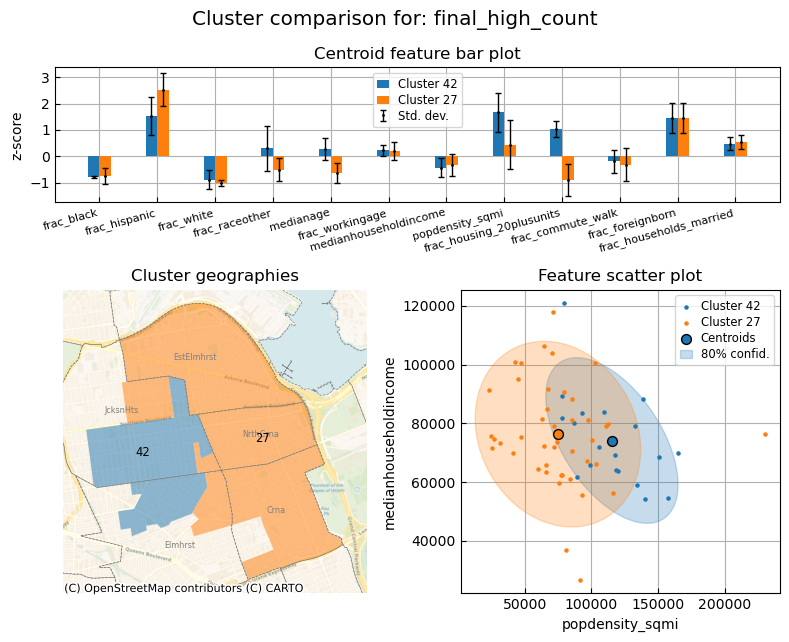

In [3]:
fig, ax = plotting.plot_cluster_comparison_summary(
    nyc_demographics, feature_attrs, "final_high_count",
    which_clusters=[42,27],plotted_attrs=["popdensity_sqmi", "medianhouseholdincome"]
)
__, __ = plotting.plot_ntas(ntas, figax=(fig, ax[1,0]), annotate=True)

Text(0.5, 1.0, 'final_high_count: frac_housing_20plusunits')

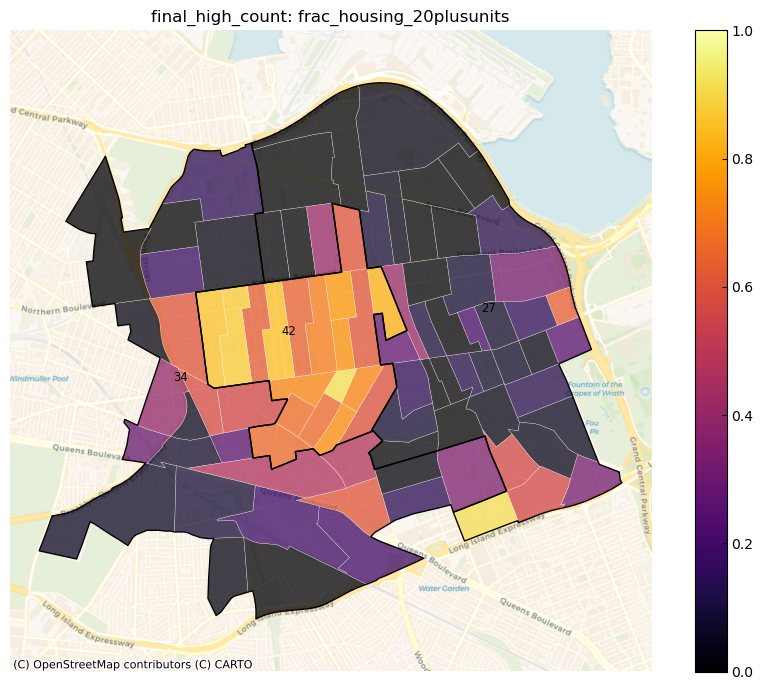

In [4]:
which_clusters = [34,42,27]
model_name = "final_high_count"
attr = "frac_housing_20plusunits"

gdf_subset = utils.get_subset_by_clusters(nyc_demographics, model_name, which_clusters)

# Make plotting.plot_feature()
fig, ax = plotting.plot_feature(gdf_subset, attr)
__, __ = plotting.plot_clusters(gdf_subset, model_name, color_clusters=False,
                                figax=(fig, ax))
ax.set_title(f"{model_name}: {attr}")

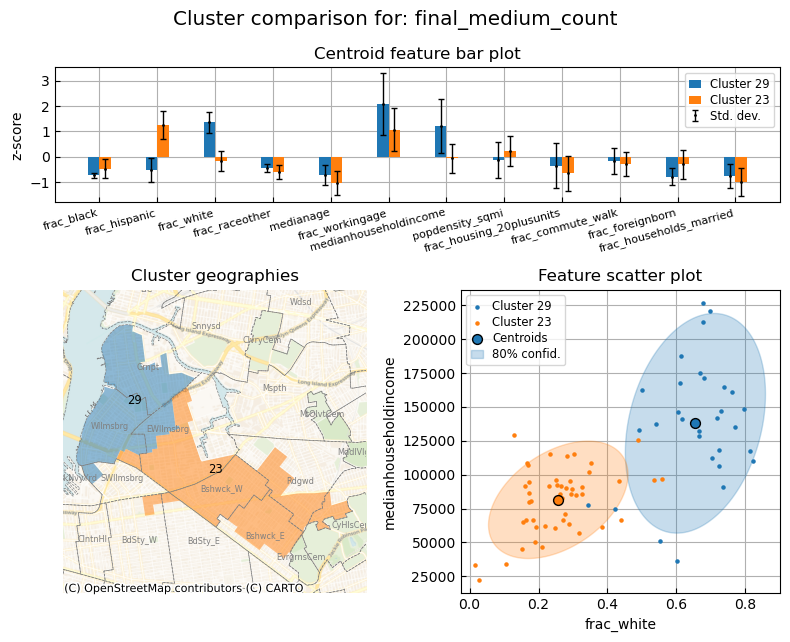

In [3]:
fig, ax = plotting.plot_cluster_comparison_summary(
    nyc_demographics, feature_attrs, "final_medium_count",
    which_clusters=[29,23],plotted_attrs=["frac_white", "medianhouseholdincome"]
)
__, __ = plotting.plot_ntas(ntas, figax=(fig, ax[1,0]), annotate=True)

Text(0.5, 1.0, 'final_medium_count: medianhouseholdincome')

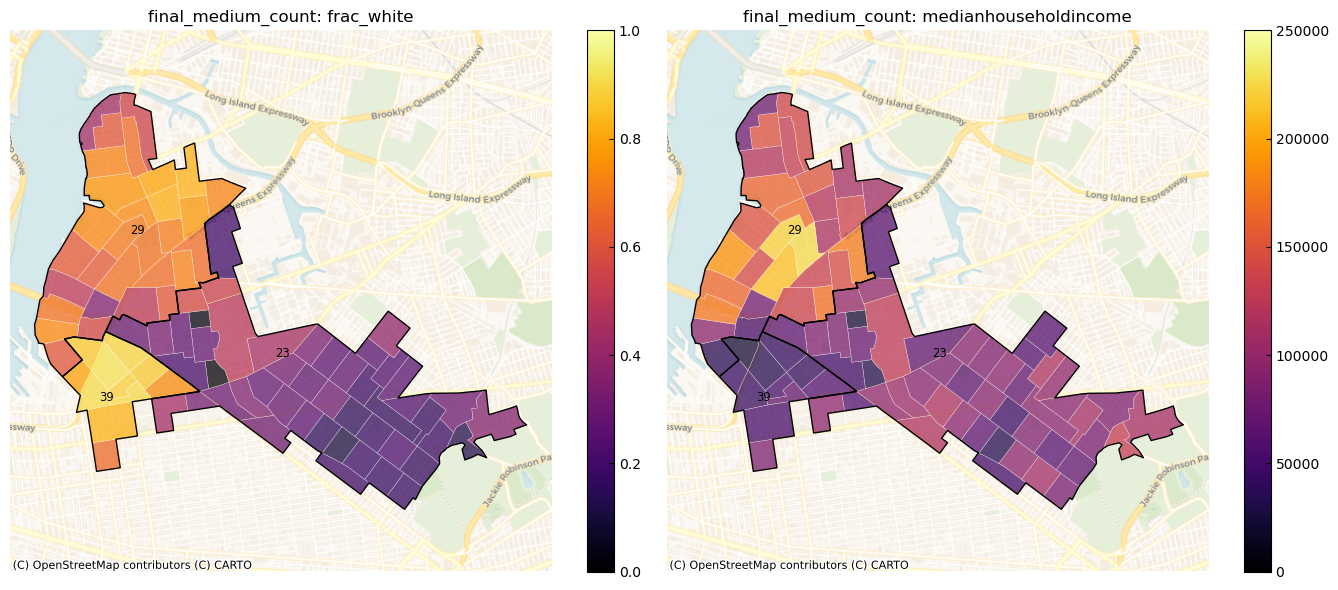

In [11]:
which_clusters = [29,23,39]
model_name = "final_medium_count"
attr_0 = "frac_white"
attr_1 = "medianhouseholdincome"

gdf_subset = utils.get_subset_by_clusters(nyc_demographics, model_name, which_clusters)

# Make plotting.plot_feature()
fig, ax = plt.subplots(1,2, figsize=(14,6))
__, __ = plotting.plot_feature(gdf_subset, attr_0, figax=(fig,ax[0]))
__, __ = plotting.plot_clusters(gdf_subset, model_name, color_clusters=False,
                                figax=(fig, ax[0]))
ax[0].set_title(f"{model_name}: {attr_0}")

__, __ = plotting.plot_feature(gdf_subset, attr_1,
                               vbounds=(0, nyc_demographics[attr_1].max()),
                               figax=(fig,ax[1]))
__, __ = plotting.plot_clusters(gdf_subset, model_name, color_clusters=False,
                                figax=(fig, ax[1]))
ax[1].set_title(f"{model_name}: {attr_1}")

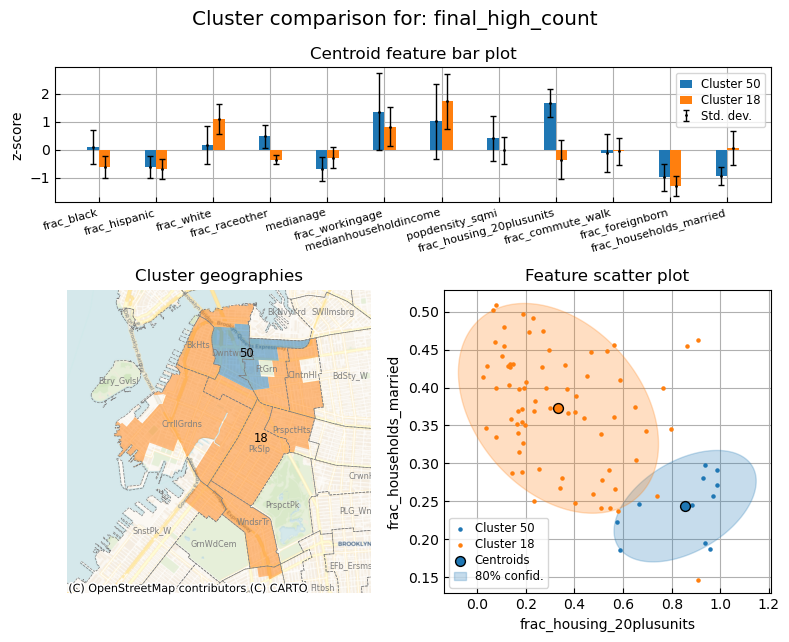

In [12]:
fig, ax = plotting.plot_cluster_comparison_summary(
    nyc_demographics, feature_attrs, "final_high_count",
    which_clusters=[50, 18]
)
__, __ = plotting.plot_ntas(ntas, figax=(fig, ax[1,0]), annotate=True)

In [12]:
utils.get_Morans_I(gdf_subset, feature_attrs)

frac_black                  0.504503
frac_hispanic               0.513077
frac_white                  0.489717
frac_raceother              0.592809
medianage                   0.410689
frac_workingage             0.377225
medianhouseholdincome       0.251094
popdensity_sqmi             0.065616
frac_housing_20plusunits    0.590639
frac_commute_walk           0.081382
frac_foreignborn            0.225243
frac_households_married     0.605774
Name: morans_I, dtype: float64

Text(0.5, 1.0, 'final_high_count: frac_households_married')

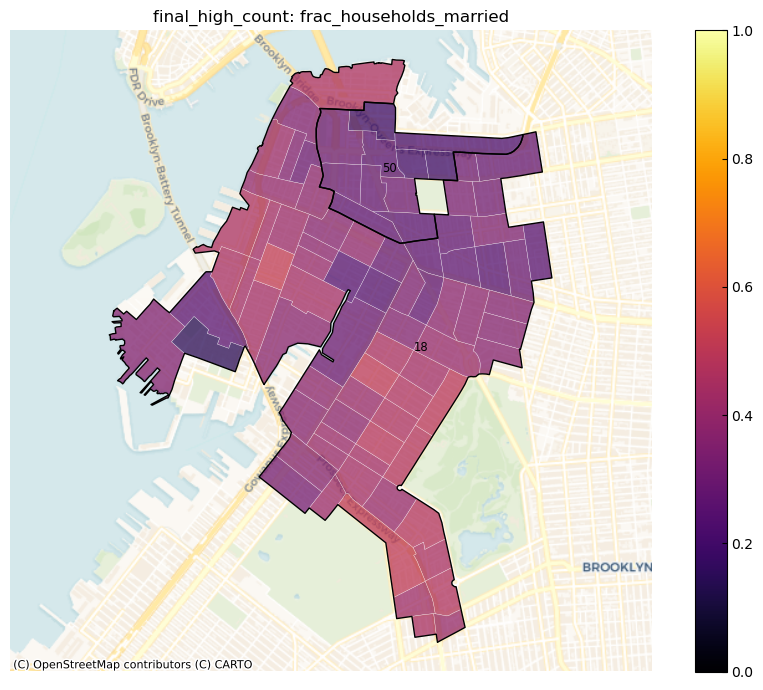

In [ ]:
which_clusters = [50,18]
model_name = "final_high_count"
attr = "frac_households_married"

gdf_subset = utils.get_subset_by_clusters(nyc_demographics, model_name, which_clusters)

# Make plotting.plot_feature()
fig, ax = plotting.plot_feature(gdf_subset, attr)
__, __ = plotting.plot_clusters(gdf_subset, model_name, color_clusters=False,
                                figax=(fig, ax))
ax.set_title(f"{model_name}: {attr}")

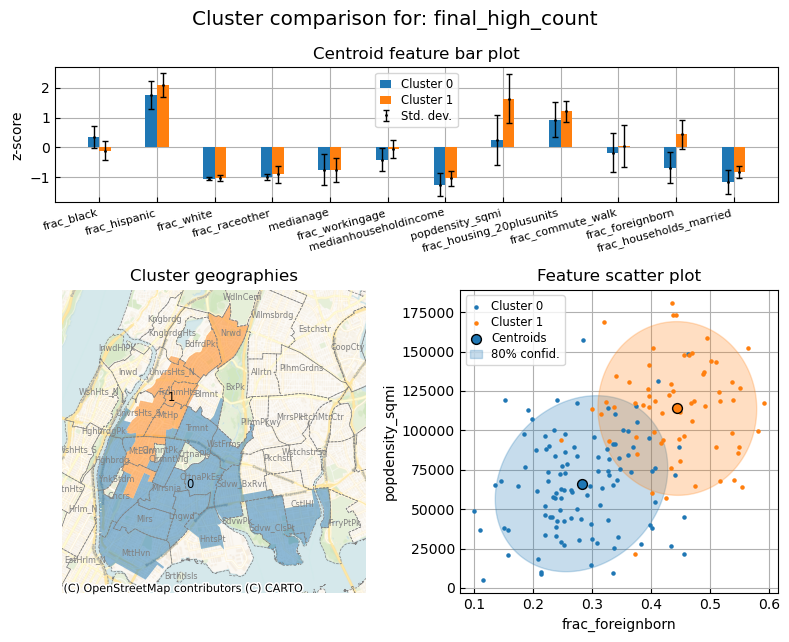

In [14]:
fig, ax = plotting.plot_cluster_comparison_summary(
    nyc_demographics, feature_attrs, "final_high_count",
    which_clusters=[0, 1]
)
__, __ = plotting.plot_ntas(ntas, figax=(fig, ax[1,0]), annotate=True)

Text(0.5, 1.0, 'final_high_count: popdensity_sqmi')

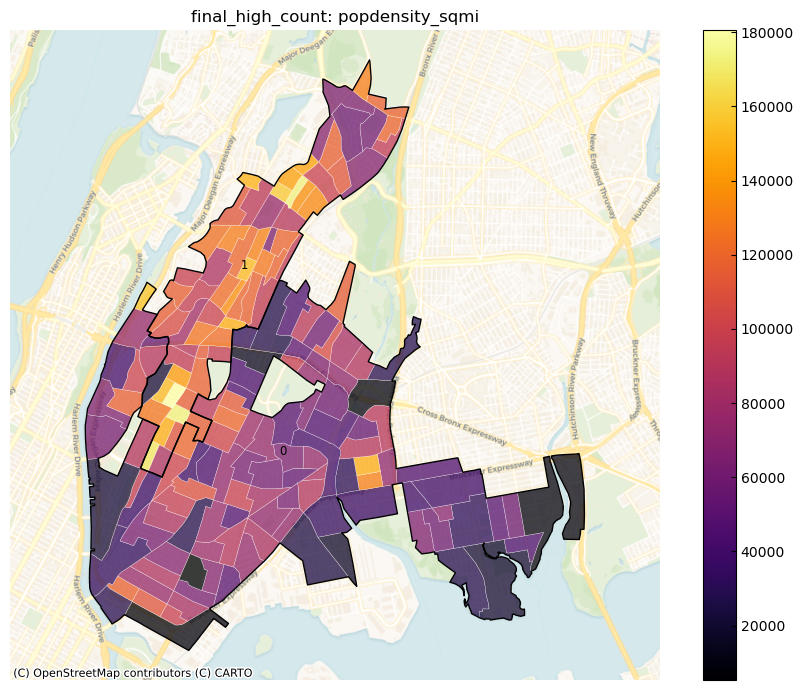

In [15]:
which_clusters = [0, 1]
model_name = "final_high_count"
attr = "popdensity_sqmi"

gdf_subset = utils.get_subset_by_clusters(nyc_demographics, model_name, which_clusters)

# Make plotting.plot_feature()
fig, ax = plotting.plot_feature(gdf_subset, attr)
__, __ = plotting.plot_clusters(gdf_subset, model_name, color_clusters=False,
                                figax=(fig, ax))
ax.set_title(f"{model_name}: {attr}")

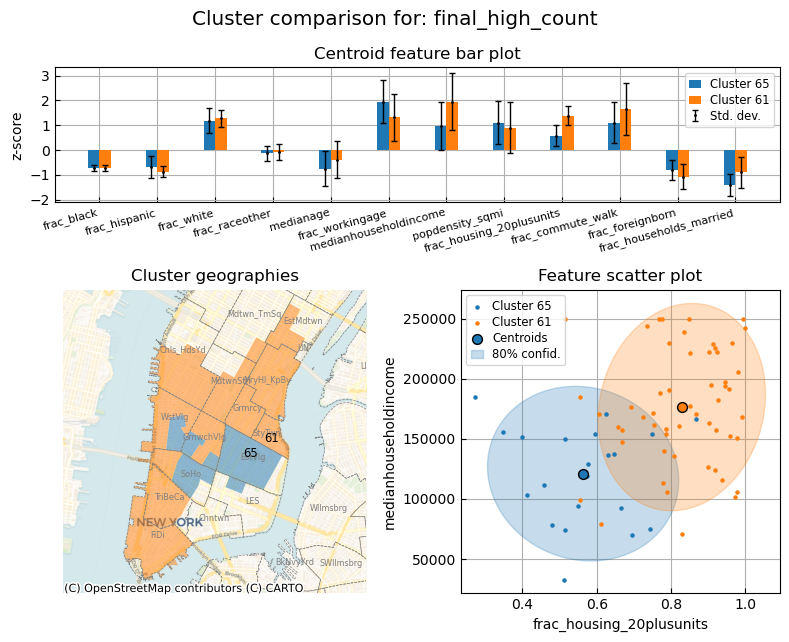

In [13]:
fig, ax = plotting.plot_cluster_comparison_summary(
    nyc_demographics, feature_attrs, "final_high_count",
    which_clusters=[65,61]
)
__, __ = plotting.plot_ntas(ntas, figax=(fig, ax[1,0]), annotate=True)

Text(0.5, 1.0, 'final_high_count: medianhouseholdincome')

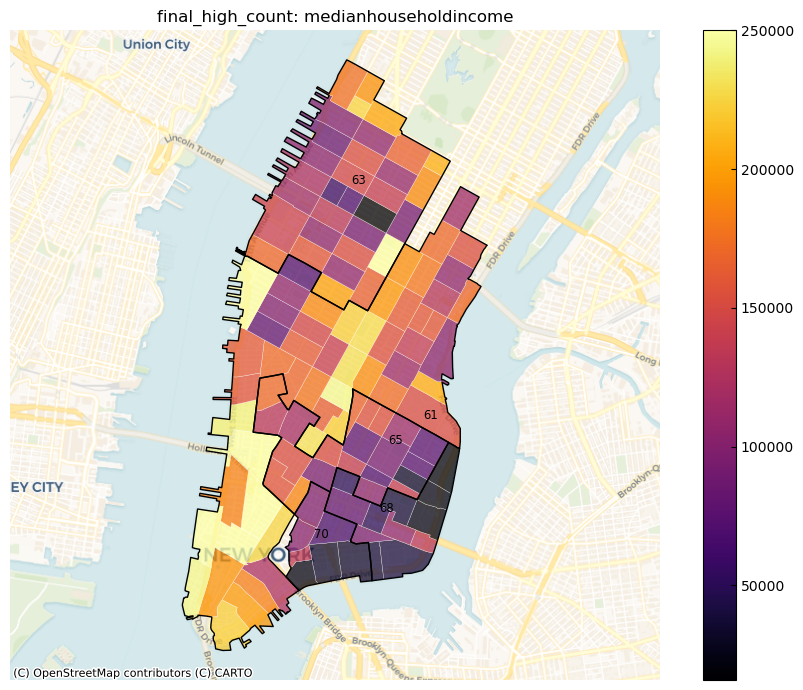

In [16]:
which_clusters = [65,61,63,68,70]
model_name = "final_high_count"
attr = "medianhouseholdincome"

gdf_subset = utils.get_subset_by_clusters(nyc_demographics, model_name, which_clusters)

# Make plotting.plot_feature()
fig, ax = plotting.plot_feature(gdf_subset, attr)
__, __ = plotting.plot_clusters(gdf_subset, model_name, color_clusters=False,
                                figax=(fig, ax))
ax.set_title(f"{model_name}: {attr}")